# German Bank Customer Segmentation

In this assignment, I will perform segmentation of German bank customers. The dataset is composed of the following variables: 
1. Age (numeric)
2. Sex (text: male, female)
3. Job (numeric: 0 - unskilled and non-resident, 1 - unskilled and resident, 2 - skilled, 3 - highly skilled)
4. Housing (text: own, rent, or free)
5. Saving accounts (text - little, moderate, quite rich, rich)
6. Checking account (numeric, in DM - Deutsch Mark)
7. Credit amount (numeric, in DM)
8. Duration (numeric, in month)
9. Purpose (text: car, furniture/equipment, radio/TV, domestic appliances, repairs, education, business, vacation/others)

From sklearn, I will import necessary pre-processing tools and two clustering algorithms: [KMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) and [Affinity Propagation](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AffinityPropagation.html).


In [51]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, AffinityPropagation
import warnings
warnings.filterwarnings("ignore")

Reading the raw data 

In [52]:
data = pd.read_csv("german_credit_data.csv")

A visual control of the first five rows.

In [53]:
data.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


It looks that the first column is simply an index which we can delete. I will check how many missing values are in each column and of what data types they are. 

In [54]:
data.drop(data.columns[0], inplace=True, axis=1)
print("Database has {} obserwations (customers) and {} columns (attributes).".format(data.shape[0],data.shape[1]))
print("Missing values in each column:\n{}".format(data.isnull().sum()))
print("Columns data types:\n{}".format(data.dtypes))

Database has 1000 obserwations (customers) and 9 columns (attributes).
Missing values in each column:
Age                   0
Sex                   0
Job                   0
Housing               0
Saving accounts     183
Checking account    394
Credit amount         0
Duration              0
Purpose               0
dtype: int64
Columns data types:
Age                  int64
Sex                 object
Job                  int64
Housing             object
Saving accounts     object
Checking account    object
Credit amount        int64
Duration             int64
Purpose             object
dtype: object


Out of 8 columns 2 contain missing values. Probably these are customers who don’t have one of these two accounts. 

Generally, there are 3 numeric variables and 5 categorical ones.

Now, I will check how many, and what are the possible (unique) values in each categorical column.

In [55]:
n_unique = data.nunique()
print("Number of unique values:\n{}".format(n_unique))

Number of unique values:
Age                  53
Sex                   2
Job                   4
Housing               3
Saving accounts       4
Checking account      3
Credit amount       921
Duration             33
Purpose               8
dtype: int64


In [56]:
print("Unique values in each categorical column:")
for col in data.select_dtypes(include=[object]):
    print(col,":", data[col].unique())

Unique values in each categorical column:
Sex : ['male' 'female']
Housing : ['own' 'free' 'rent']
Saving accounts : [nan 'little' 'quite rich' 'rich' 'moderate']
Checking account : ['little' 'moderate' nan 'rich']
Purpose : ['radio/TV' 'education' 'furniture/equipment' 'car' 'business'
 'domestic appliances' 'repairs' 'vacation/others']


**Exploratory Data Analysis**

Below I will define a function which will generate plots for three numeric variables with stratification by selected categorical column.

In [57]:
def scatters(data, h=None, pal=None):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.scatterplot(x="Credit amount",y="Duration", hue=h, palette=pal, data=data, ax=ax1)
    sns.scatterplot(x="Age",y="Credit amount", hue=h, palette=pal, data=data, ax=ax2)
    sns.scatterplot(x="Age",y="Duration", hue=h, palette=pal, data=data, ax=ax3)
    plt.tight_layout()

At the beginning let’s look at scatter plots our 3 numerical variables stratified by sex.

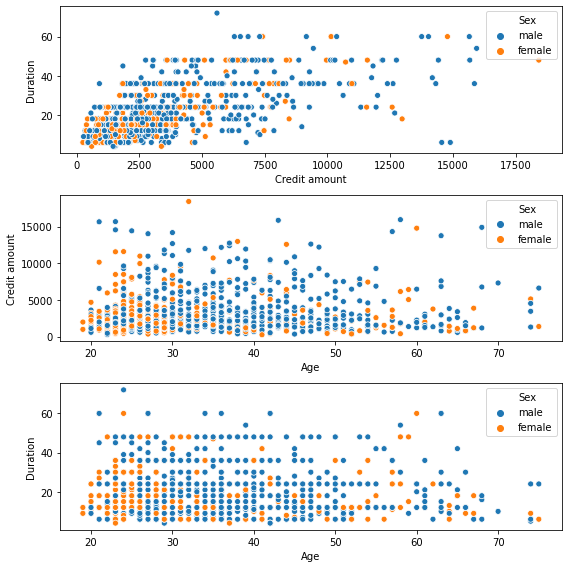

In [58]:
scatters(data, h="Sex")

The general impression is that women tend to be younger than men, however, the top plot shows that there is no clear difference between men and women in terms of amount and duration of the credit. From visual inspection, it seems that there is some positive correlation between duration and amount of credit, what makes sense. 

Let’s check the linear correlation between credit amount and duration

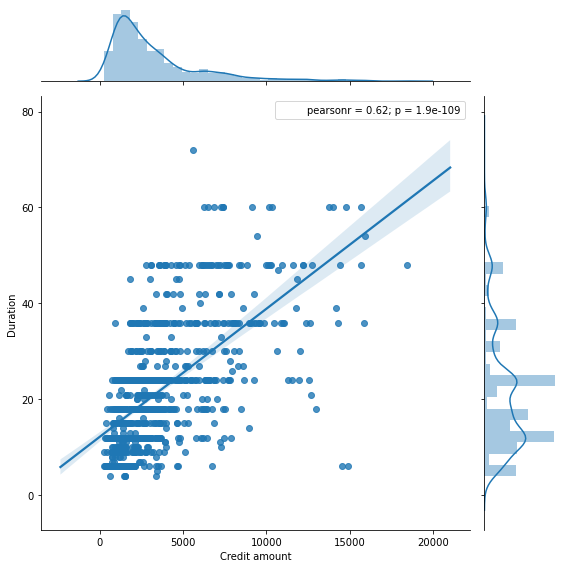

In [59]:
import scipy.stats as stats
r1 = sns.jointplot(x="Credit amount",y="Duration", data=data, kind="reg", height=8)
r1.annotate(stats.pearsonr)
plt.show()

The plot above shows a linear correlation with Pearson value of 0.62 and very small p-value. That make’s sense because usually, people take bigger credits for longer periods.  Below I will analyse linear regression plots with various categorisations.

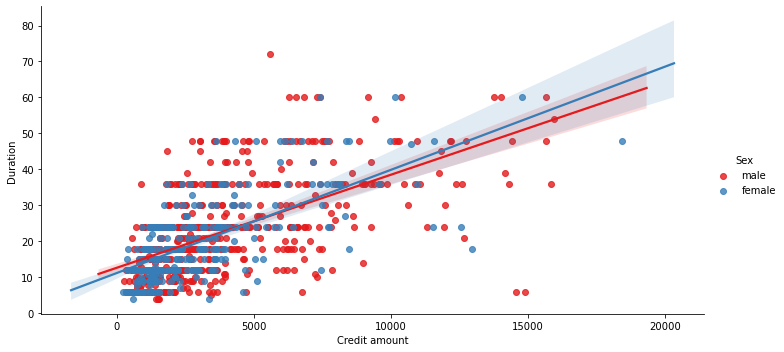

In [60]:
sns.lmplot(x="Credit amount",y="Duration", hue="Sex", data=data, palette="Set1", aspect=2)
plt.show()

The plot above indicates that there is no significant difference between men and women.

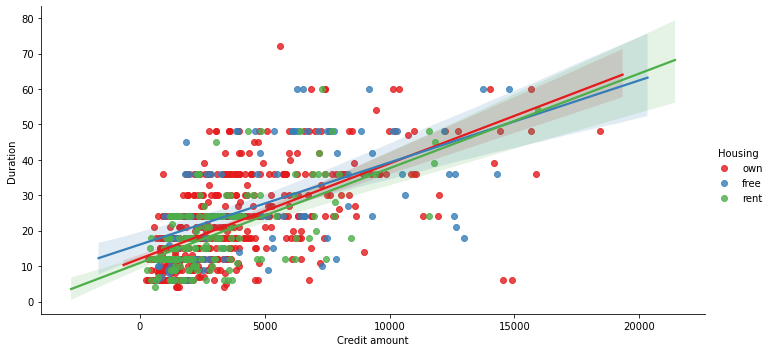

In [61]:
sns.lmplot(x="Credit amount",y="Duration", hue="Housing", data=data, palette="Set1", aspect=2)
plt.show()

The plot above shows similarly that there is no diference betwen housing categories.

Below I will show “business” area where granted the biggest amount of credits. 

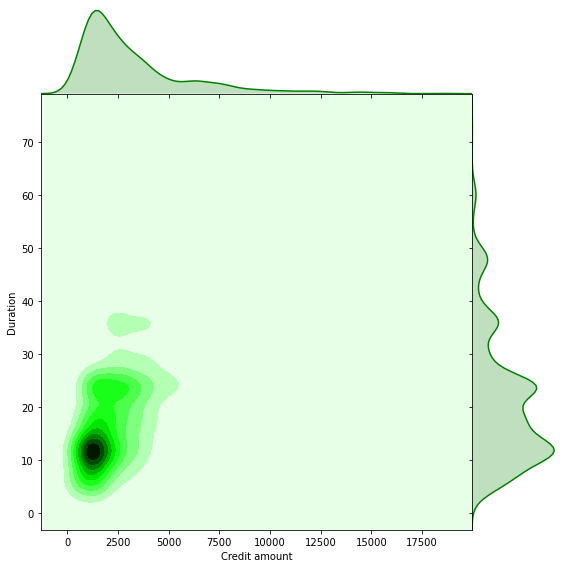

In [62]:
sns.jointplot("Credit amount","Duration", data=data, kind="kde", space=0, color="g",  height=8)
plt.show()

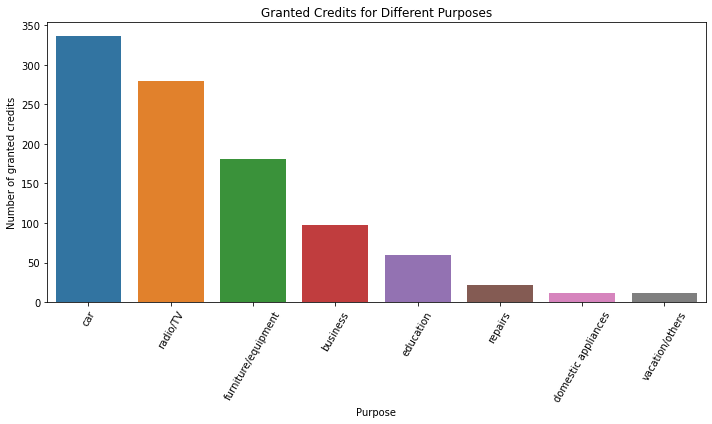

In [63]:
n_credits = data.groupby("Purpose")["Age"].count().rename("Count").reset_index()
n_credits.sort_values(by=["Count"], ascending=False, inplace=True)

plt.figure(figsize=(10,6))
bar = sns.barplot(x="Purpose",y="Count",data=n_credits)
bar.set_xticklabels(bar.get_xticklabels(), rotation=60)
plt.ylabel("Number of granted credits")
plt.title('Granted Credits for Different Purposes')
plt.tight_layout()

The barplot above shows how many credits were granted for various purposes. Most of credits were granted for car and radio/TV.

Now I will generate boxplots for detailed analysis of categorical variables.

In [64]:
def boxes(x,y,h,r=45):
    fig, ax = plt.subplots(figsize=(10,6))
    box = sns.boxplot(x=x,y=y, hue=h, data=data)
    box.set_xticklabels(box.get_xticklabels(), rotation=r)
    fig.subplots_adjust(bottom=0.2)
    plt.title('Granted Credits for Different Purposes by Gender')
    plt.tight_layout()

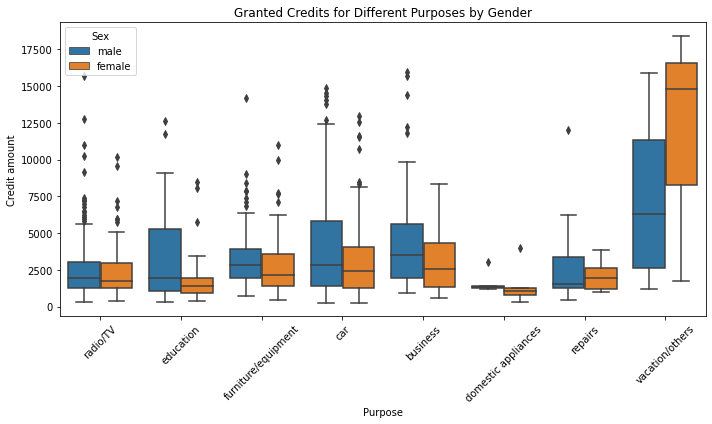

In [65]:
boxes("Purpose","Credit amount","Sex")

The plot above shows that the biggest amounts are taken for vacations/others, the smallest for domestic appliances. Most of them have outliers on the upper side of the boxes (higher amounts). In most of the cases there is no difference between men and women, despite category vacation/others. But one must remember that there was very little number of credits granted in this category. 

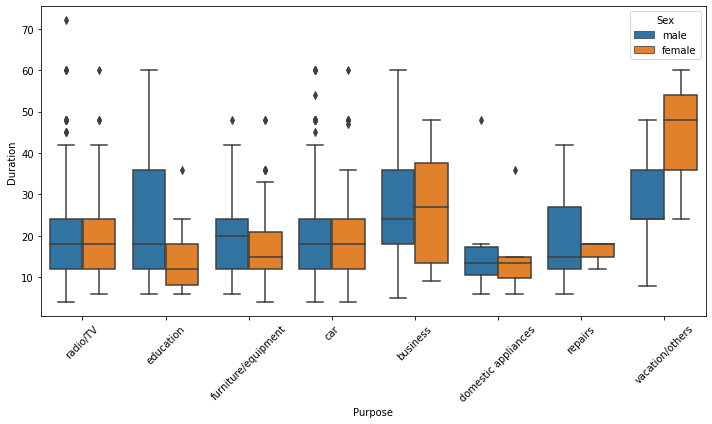

In [16]:
boxes("Purpose","Duration","Sex")

The boxplot above indicates that generally there is no difference in credit duration between men and women. We can’t see also clear trend between categories with observations that the shortest duration is for domestic appliances.  It makes sense as it is in agreement with insights from the previous graph (credit amount) – in this category, there are the lowest amounts of credits.

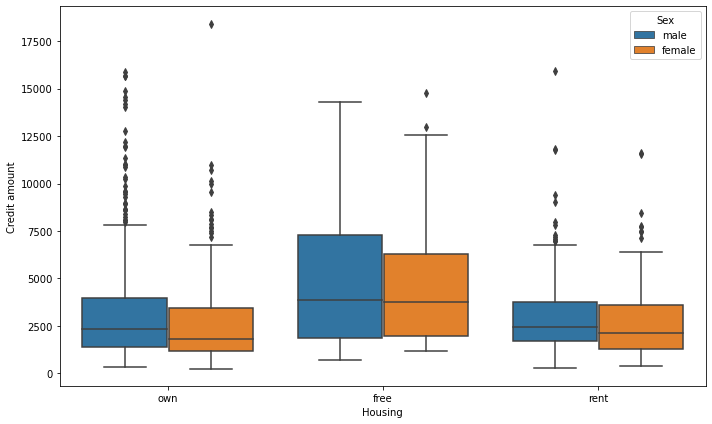

In [17]:
boxes("Housing","Credit amount","Sex",r=0)

In terms of housing category, there is no big difference despite people having “free” housing tend to take slightly bigger credit amounts.

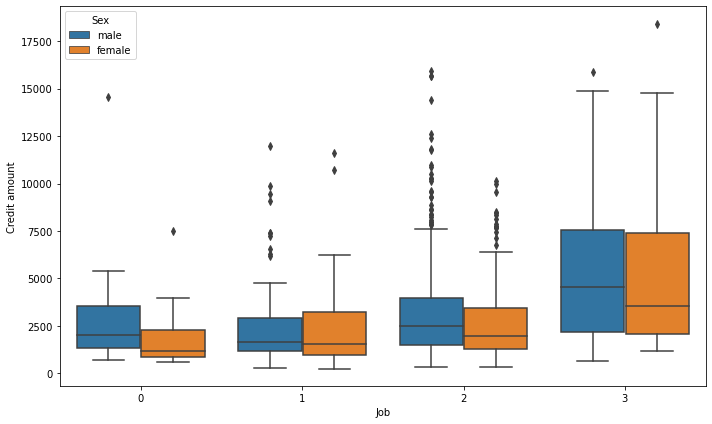

In [18]:
boxes("Job","Credit amount","Sex",r=0)

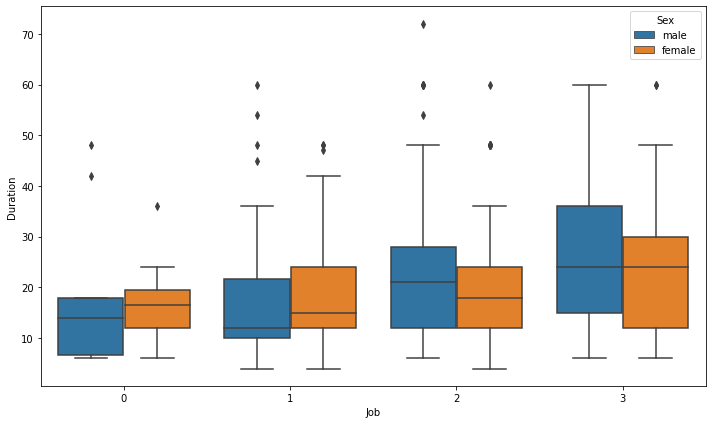

In [19]:
boxes("Job","Duration","Sex",r=0)

In terms of job category once again there is no difference between men and women, but we can see that job category 3 tends to take bigger credit amounts for longer duration.  

And at the end if someone likes 3D plots here you go.

Text(0.5, 0, 'Age')

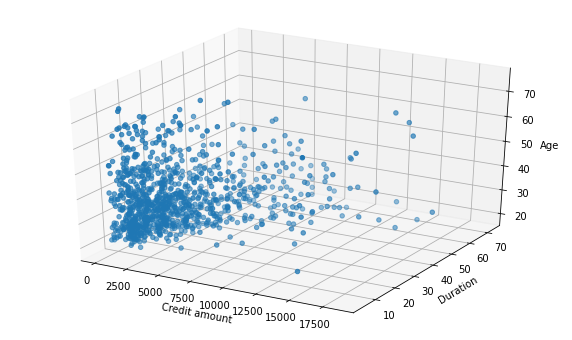

In [20]:
from mpl_toolkits.mplot3d import Axes3D 
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(data["Credit amount"], data["Duration"], data["Age"])
ax.set_xlabel("Credit amount")
ax.set_ylabel("Duration")
ax.set_zlabel("Age")

**Clustering with KMeans**

For clustering, I will create a subset containing only numerical variables (Age, Credit amount, Duration). 

In [21]:
#Selecting columns for clusterisation with k-means
selected_cols = ["Age","Credit amount", "Duration"]
cluster_data = data.loc[:,selected_cols]

I will create a function which plots three histograms - one for each variable. 

In [22]:
def distributions(df):
    fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,8))
    sns.distplot(df["Age"], ax=ax1)
    sns.distplot(df["Credit amount"], ax=ax2)
    sns.distplot(df["Duration"], ax=ax3)
    plt.tight_layout()

Let's look at the histograms.

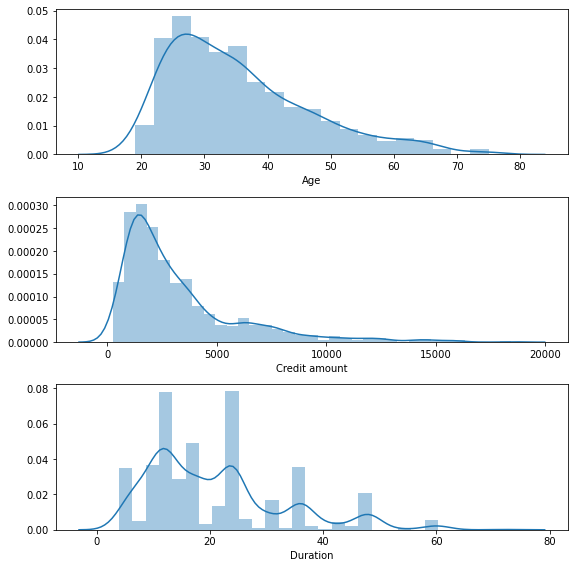

In [23]:
distributions(cluster_data)

We can see that distributions are right-skewed. To obtain better results we should remove the skewness by logarithmic transformation. After that let's see how they look like.

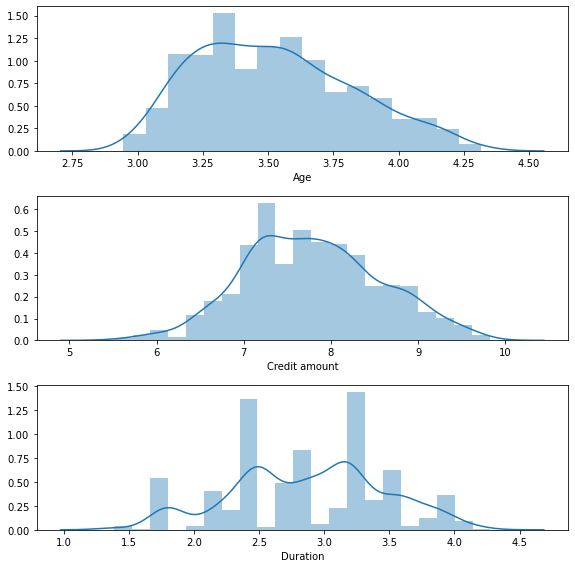

In [24]:
cluster_log = np.log(cluster_data)
distributions(cluster_log)

Indeed, the skewness has been eliminated. 

The next step will be centering and scaling of variables – it is required by KMeans algorithm.  We will use for that a StandardScaler from sklearn library. 

In [25]:
scaler = StandardScaler()
cluster_scaled = scaler.fit_transform(cluster_log)

I will check how inertia changes for various number of clusters.

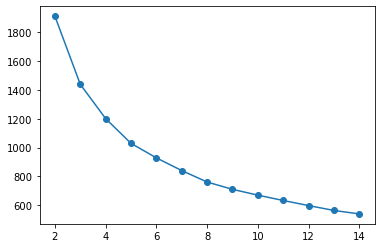

In [26]:
clusters_range = [2,3,4,5,6,7,8,9,10,11,12,13,14]
inertias =[]

for c in clusters_range:
    kmeans = KMeans(n_clusters=c, random_state=0).fit(cluster_scaled)
    inertias.append(kmeans.inertia_)

plt.figure()
plt.plot(clusters_range,inertias, marker='o')

The plot above shows that inertia decreases with increasing number of clusters. 

This method allows for assessment of cluster separations and fitting of each observation in its own cluster.  The highest score the better.  I will perform this analysis for various seeds as well.

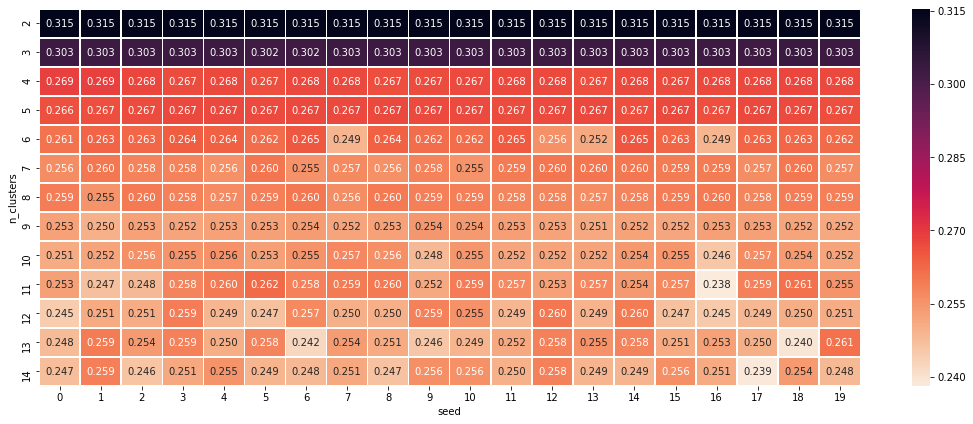

In [27]:
from sklearn.metrics import silhouette_samples, silhouette_score

clusters_range = range(2,15)
random_range = range(0,20)
results =[]
for c in clusters_range:
    for r in random_range:
        clusterer = KMeans(n_clusters=c, random_state=r)
        cluster_labels = clusterer.fit_predict(cluster_scaled)
        silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
        #print("For n_clusters =", c," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)
        results.append([c,r,silhouette_avg])

result = pd.DataFrame(results, columns=["n_clusters","seed","silhouette_score"])
pivot_km = pd.pivot_table(result, index="n_clusters", columns="seed",values="silhouette_score")

plt.figure(figsize=(15,6))
sns.heatmap(pivot_km, annot=True, linewidths=.5, fmt='.3f', cmap=sns.cm.rocket_r)
plt.tight_layout()

The heatmap above shows silhouette scores for various combinations of random state and number of clusters. The highest scores are for 2 and 3 clusters and they are relatively insensitive to seed. 

I will chose 3 clusters to get more insight into data.

In [28]:
kmeans_sel = KMeans(n_clusters=3, random_state=1).fit(cluster_scaled)
labels = pd.DataFrame(kmeans_sel.labels_)
clustered_data = cluster_data.assign(Cluster=labels)

Below I will create silhouette graph for 3 clusters in order to visually depict fit of each point within its own cluster (modified code from scikit-learn doc).

For n_clusters = 3  and seed = 19 
The average silhouette_score is : 0.30318933408774545


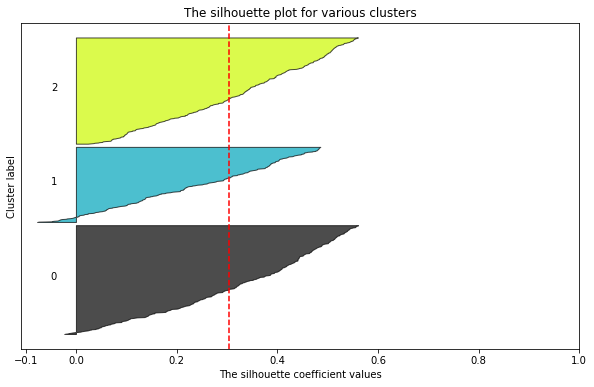

In [29]:
import matplotlib.cm as cm

clusterer = KMeans(n_clusters=3, random_state=1)
cluster_labels = clusterer.fit_predict(cluster_scaled)
silhouette_avg = silhouette_score(cluster_scaled, cluster_labels)
print("For n_clusters =", 3," and seed =", r,  "\nThe average silhouette_score is :", silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(cluster_scaled, cluster_labels)

fig, ax1 = plt.subplots(figsize=(10,6))

y_lower = 10
for i in range(3):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    
    color = cm.nipy_spectral(float(i) / 3)
    ax1.fill_betweenx(np.arange(y_lower, y_upper),0, ith_cluster_silhouette_values, facecolor=color, edgecolor="black", alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
    
    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

ax1.get_yaxis().set_ticks([])
ax1.set_title("The silhouette plot for various clusters")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")
# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

I will define a function showing clusters on the scatter plot.  

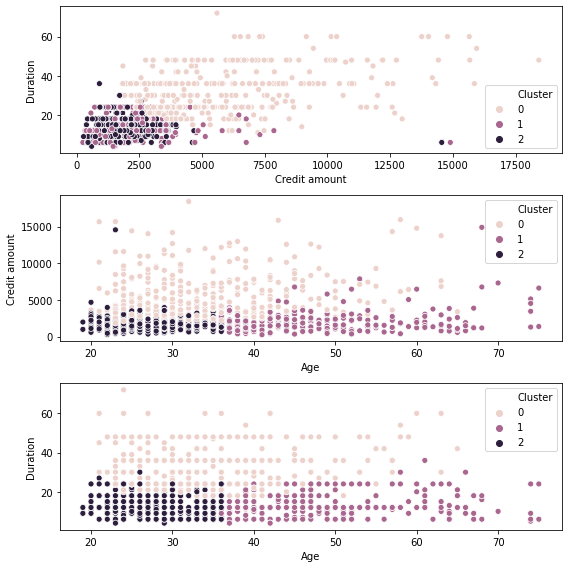

In [30]:
scatters(clustered_data, 'Cluster')

Plots above show three created clusters. Two bottom ones show relatively clear separation of clusters, but it is no so evident on the top one. 
I will generate radar charts for easier business interpretation of customer segmentation.

In [43]:
grouped_km = clustered_data.groupby(['Cluster']).mean().round(1)

In [44]:
# Here are codes for building a radar chart to illustrate differences between KMeans clusters
def _scale_data(data, ranges):
    (x1, x2) = ranges[0]
    d = data[0]
    return [(d - y1) / (y2 - y1) * (x2 - x1) + x1 for d, (y1, y2) in zip(data, ranges)]


class RadarChart():
    def __init__(self, fig, variables, ranges, n_ordinate_levels = 6):
        angles = np.arange(0, 360, 360./len(variables))

        axes = [fig.add_axes([0.1,0.1,0.8,0.8],polar = True, 
        label = "axes{}".format(i)) for i in range(len(variables))]
        _, text = axes[0].set_thetagrids(angles, labels = variables)
        
        for txt, angle in zip(text, angles):
            txt.set_rotation(angle - 90)
        
        for ax in axes[1:]:
            ax.patch.set_visible(False)
            ax.xaxis.set_visible(False)
            ax.grid("off")
        
        for i, ax in enumerate(axes):
            grid = np.linspace(*ranges[i],num = n_ordinate_levels)
            grid_label = [""]+["{:.1f}".format(x) for x in grid[1:]]
            ax.set_rgrids(grid, labels = grid_label, angle = angles[i])
            ax.set_ylim(*ranges[i])
            self.angle = np.deg2rad(np.r_[angles, angles[0]])
        self.ranges = ranges
        self.ax = axes[0]

    def plot(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.plot(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def fill(self, data, *args, **kw):
        sdata = _scale_data(data, self.ranges)
        self.ax.fill(self.angle, np.r_[sdata, sdata[0]], *args, **kw)

    def legend(self, *args, **kw):
        self.ax.legend(*args, **kw)
        
    def title(self, title, *args, **kw):
        self.ax.text(0.9, 1, title, transform = self.ax.transAxes, *args, **kw)

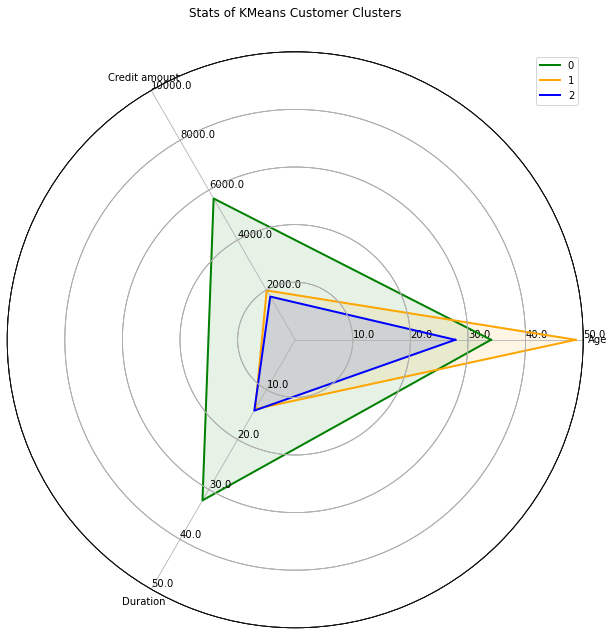

,Age,Credit amount,Duration
Cluster,,,
0,34.0,5665.4,32.2
1,48.7,1979.7,13.9
2,27.8,1732.2,14.2


In [45]:
fig = plt.figure(figsize=(10,10))
 
attributes = ['Age', 'Credit amount', 'Duration']
index  = [0, 1, 2]
ranges = [[0.01, 50], [0.01, 10000], [0.01, 50]]
colors = ["green","orange","blue"]
cluster_types = ["0","1","2"]

data = np.array(grouped_km.loc[index, attributes])  
radar = RadarChart(fig, attributes, ranges)
for data, color, cluster_type in zip(data, colors, cluster_types):
    radar.plot(data, color = color, label = cluster_type, linewidth=2.0)
    radar.fill(data, alpha = 0.1, color = color)
    radar.legend(loc = 1, fontsize = 'medium')
plt.title('Stats of KMeans Customer Clusters')
plt.show() 

grouped_km

Cluster 0 –  lower mean of credit amount, short duration, older customers

Cluster 1 – high mean of credit amount, long duration, middle-aged customers

Cluster 2 - lower mean of credit amount, short duration, young customers

**Clustering with Affinity Propagation**

In this algorithm there are two relevant parameters: preference and dumping. It means that we don’t define upfront number of clusters, algorithm itself chooses their number. I will fix dumping and check number of clusters in function of preference parameter.  

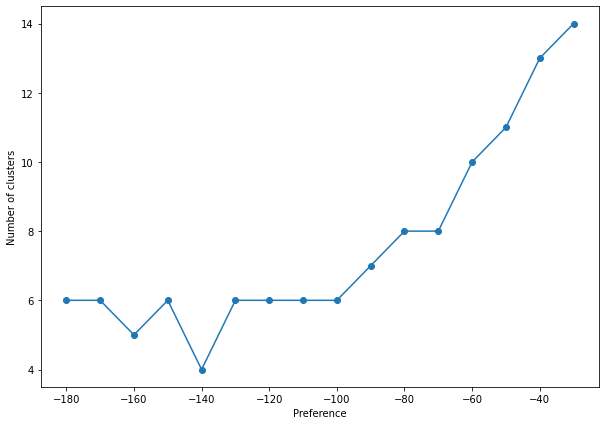

In [32]:
preferences = np.arange(-30,-190,-10)
clusters = []

for p in preferences:
    af = AffinityPropagation(preference=p, damping=0.6, max_iter=400, verbose=False).fit(cluster_scaled)
    labels_af = pd.DataFrame(af.labels_)
    clusters.append(len(af.cluster_centers_indices_))

plt.figure(figsize=(10,7))
plt.xlabel("Preference")
plt.ylabel("Number of clusters")
plt.plot(preferences,clusters, marker='o')


Together with decreasing value of preference parameter number of clusters goes down as well and levels for very small preference values. I will check four clusters option. 

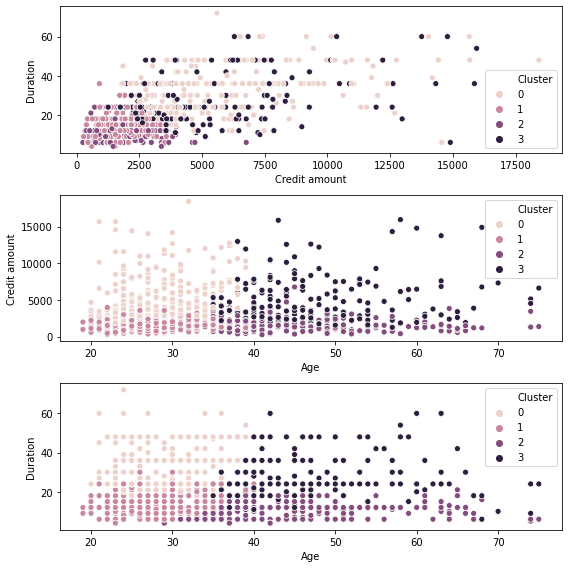

In [33]:
af = AffinityPropagation(preference=-140, damping=0.6, verbose=False).fit(cluster_scaled)
labels_af = pd.DataFrame(af.labels_)
n_clusters_ = len(af.cluster_centers_indices_)

clustered_data_af = cluster_data.assign(Cluster=labels_af)
scatters(clustered_data_af,'Cluster')

grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)


In [46]:
grouped_af = clustered_data_af.groupby(['Cluster']).mean().round(1)

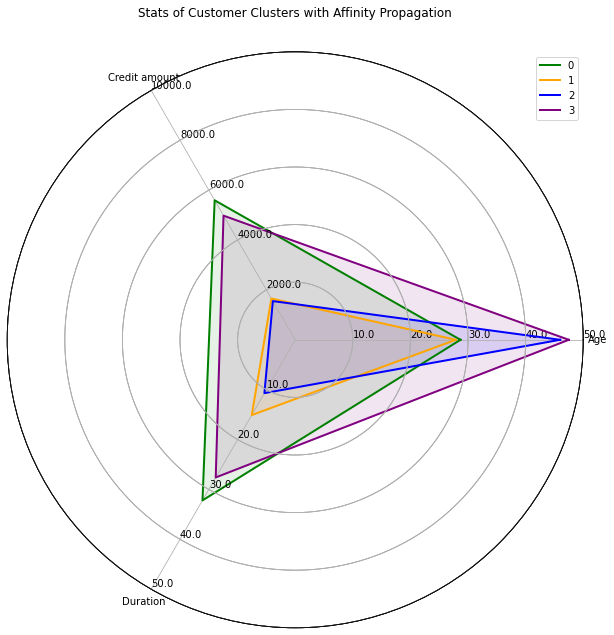

,Age,Credit amount,Duration
Cluster,,,
0,28.7,5593.7,32.2
1,27.9,1654.3,15.1
2,46.0,1551.7,10.7
3,47.5,4977.9,27.6


In [49]:
# Here are codes for building a radar chart to illustrate differences between clusters with Affinity Propagation
fig = plt.figure(figsize=(10,10))
 
attributes = ['Age', 'Credit amount', 'Duration']
index  = [0, 1, 2, 3]
ranges = [[0.01, 50], [0.01, 10000], [0.01, 50]]
colors = ["green","orange","blue", "purple"]
cluster_types = ["0","1","2","3"]

data = np.array(grouped_af.loc[index, attributes])  
radar = RadarChart(fig, attributes, ranges)
for data, color, cluster_type in zip(data, colors, cluster_types):
    radar.plot(data, color = color, label = cluster_type, linewidth=2.0)
    radar.fill(data, alpha = 0.1, color = color)
    radar.legend(loc = 1, fontsize = 'medium')
plt.title('Stats of Customer Clusters with Affinity Propagation')
plt.show() 

grouped_af

Cluster 0 – high mean of credit amount, long duration, younger customers

Cluster 1 – low mean of credit amount, short duration, younger customers

Cluster 2 - low mean of credit amount, short duration, older customers

Cluster 3 - high mean of credit amount, middle-time duration, older customers